# Hebridean Whale and Dolphin Trust #
## Data Wrangling ##

---
This notebook wrangles the supplied data in to something we can work with.

--- 

Data provided by the following providers:<br><br>

<ul><li>Records provided by Hebridean Whale and Dolphin Trust, accessed through NBN Atlas website. (). For more information: email info@hwdt.org, or https://registry.nbnatlas.org/public/show/dp81</li><li>Hebridean Whale and Dolphin Trust (2022). Visual sightings data set 2003-2021. Occurrence dataset on the NBN Atlas (Creative Commons, with Attribution, Non-commercial v4.0 (CC-BY-NC) CC-BY-NC). For more information: email biodiversityofficer@hwdt.org, or https://registry.nbnatlas.org/public/show/dr537</li></ul>

---

## Imports

In [ ]:
%%capture
!pip install OSGridConverter

In [32]:
import pandas as pd
from datetime import datetime, date, time
#import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#from bokeh.plotting import figure, show
#from bokeh.models import ColumnDataSource
#from bokeh.models import NumeralTickFormatter
#from bokeh.io import output_notebook
#output_notebook()

import plotly.express as px

import seaborn as sns

import folium

from OSGridConverter import latlong2grid



## Parameter setup

In [84]:
import_file = 'Data/records-2022-11-02.csv'
export_file = 'Data/export-2022.csv'

years = []
for f in range(2003,2022):
    years.append(str(f))

col_to_drop = ["NBN Atlas record ID","Licence","Rightsholder","Occurrence status","Taxon author","Taxon Rank","Country","Recorder","Dataset ID","Data provider","Dataset name","Data provider ID",'Class','Order','Family','Kingdom','Basis of record','Species ID (TVK)','Institution code','Vitality','Identification verification status','Phylum','Genus','OSGR 100km','OSGR 10km','OSGR 2km','OSGR 1km']

Functions

In [113]:
def getOSGrid(row): # precision 10=1m, 8=10m, 6=100m, 4=1k, 2=10k, 0=100k
    
    osg = latlong2grid(row.Latitude, row.Longitude, tag = 'WGS84')

    row['OSGR'] = str(osg).replace(' ','')

    osglist = str(osg).split()

    row['OSG 10m'] = str(osglist[0]) + str(osglist[1][0:4]) + str(osglist[2][0:4])
    row['OSG 100m'] = str(osglist[0]) + str(osglist[1][0:3]) + str(osglist[2][0:3])
    row['OSG 1km'] = str(osglist[0]) + str(osglist[1][0:2]) + str(osglist[2][0:2])
    row['OSG 10km'] = str(osglist[0]) + str(osglist[1][0:1]) + str(osglist[2][0:1])
    row['OSG 100km'] = str(osglist[0])
    
    return row


## Import Data

In [114]:
dw = pd.read_csv(import_file, parse_dates=["Start date"])
dw.shape

(13973, 56)

## Data Cleanse

In [115]:
# Drop columns we don't need
dw = dw.drop(col_to_drop, axis='columns', errors='ignore')
# drop empty columns
dw = dw.dropna(axis='columns', how='all') 

In [116]:
# Rename columns
dw.columns = dw.columns.str.replace("Start date","Date")
dw.columns = dw.columns.str.replace("State/Province","Country")
dw.columns = dw.columns.str.replace(" (WGS84)","", regex=False)
dw.head()

,Occurrence ID,Scientific name,Common name,Date,Date day,Date month,Date year,OSGR,Latitude,Longitude,Coordinate uncertainty (m),Individual count,Life stage,Country
0,13277,Orcinus orca,Killer Whale,2019-12-20,20,12,2019,NM36,56.667782,-6.296667,1000.0,NaN,NaN,Scotland
1,13273,Halichoerus grypus,Grey Seal,2019-11-26,26,11,2019,NM3966,56.720737,-6.260450,220.0,NaN,NaN,Scotland
2,13271,Phocoena phocoena,Common Porpoise,2019-11-26,26,11,2019,NM5976,56.815250,-5.942466,400.0,NaN,NaN,Scotland
3,14169,Delphinus delphis,Common Dolphin,2021-11-05,5,11,2021,NM2470,56.742290,-6.507234,150.0,NaN,NaN,Scotland
4,13261,Phocoena phocoena,Common Porpoise,2019-11-25,25,11,2019,NM5175,56.805698,-6.072366,200.0,NaN,NaN,Scotland


In [117]:
# Graph missing data
null_plot = dw.isna().sum()
null_plot = null_plot[null_plot > 0]
null_plot = null_plot.sort_values()
px.bar(null_plot, orientation='h',text_auto=True, title='Missing data').update_layout(yaxis_title='Column', xaxis_title='Count', showlegend=False)

Repair Individual Count

In [118]:
# Repair Individual count data
# Fill missing counts with 1
dw['Individual count'] = dw['Individual count'].fillna(1)
# Reduce outliers to 1
dw.loc[dw['Individual count'] > 100, 'Individual count'] = 1

Repair Life Stage

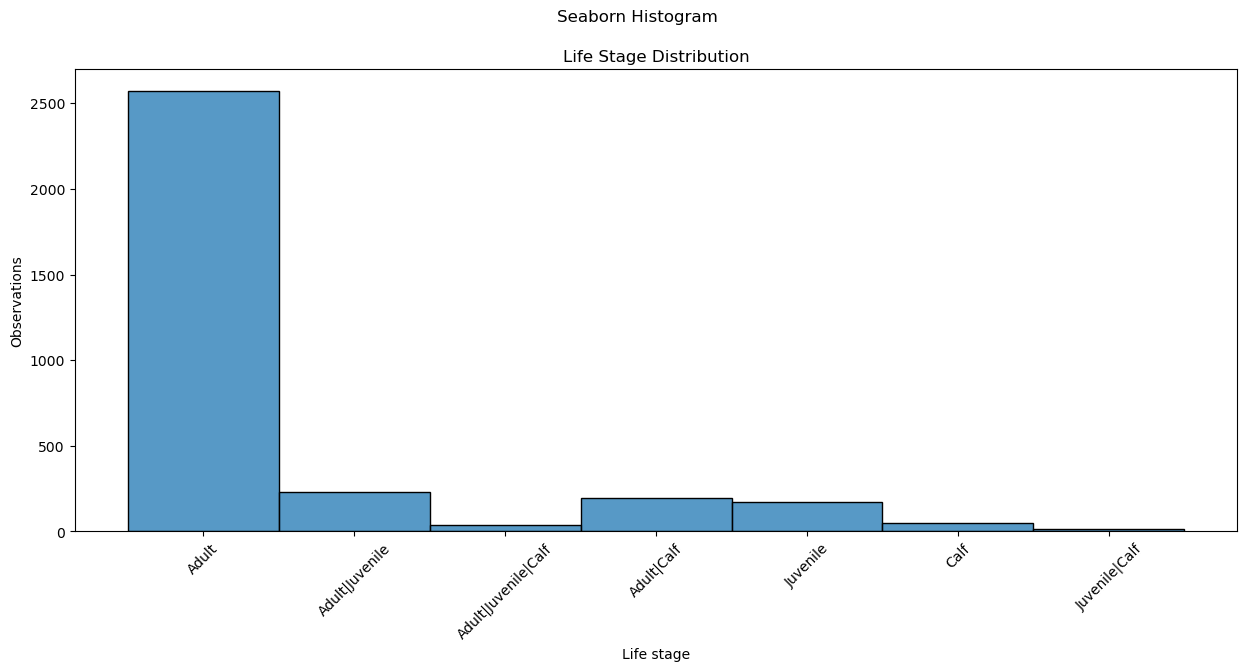

In [119]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(data=dw, x='Life stage')
fig.suptitle('Seaborn Histogram')
ax.set_title("Life Stage Distribution")
ax.set_ylabel('Observations')
ax.tick_params(axis='x', rotation=45)
plt.show()

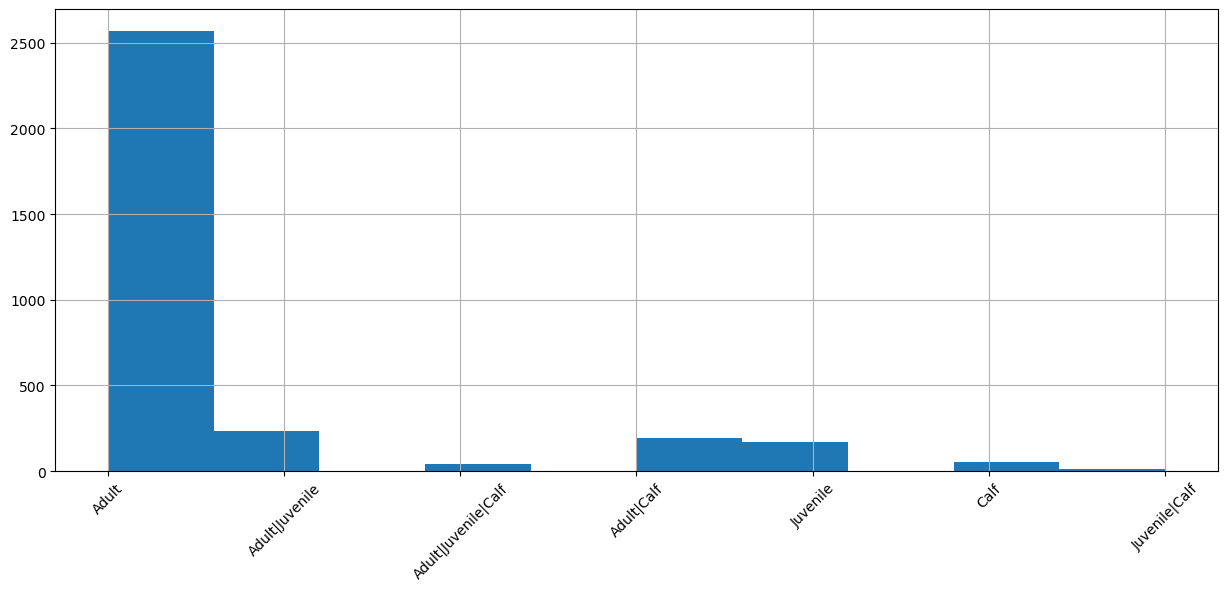

In [120]:
dw['Life stage'].hist(xrot=45,figsize=(15,6))
plt.show()

In [121]:
# Set missing Life stage to Adult
dw['Life stage'] = dw['Life stage'].fillna('Adult')

In [122]:
fig = px.histogram(dw, x='Life stage', orientation='v',text_auto=True)
fig.update_layout(yaxis_title='Observations', xaxis_title='Life Stage')
fig.show()

Fix OS Grid reference

In [123]:
dw = dw.apply(getOSGrid, axis=1)

In [124]:
dw.head()

,Occurrence ID,Scientific name,Common name,Date,Date day,Date month,Date year,OSGR,Latitude,Longitude,Coordinate uncertainty (m),Individual count,Life stage,Country,OSG 10m,OSG 100m,OSG 1km,OSG 10km,OSG 100km
0,13277,Orcinus orca,Killer Whale,2019-12-20,20,12,2019,NM3685461143,56.667782,-6.296667,1000.0,1.0,Adult,Scotland,NM36856114,NM368611,NM3661,NM36,NM
1,13273,Halichoerus grypus,Grey Seal,2019-11-26,26,11,2019,NM3943766893,56.720737,-6.260450,220.0,1.0,Adult,Scotland,NM39436689,NM394668,NM3966,NM36,NM
2,13271,Phocoena phocoena,Common Porpoise,2019-11-26,26,11,2019,NM5948576238,56.815250,-5.942466,400.0,1.0,Adult,Scotland,NM59487623,NM594762,NM5976,NM57,NM
3,14169,Delphinus delphis,Common Dolphin,2021-11-05,5,11,2021,NM2450970256,56.742290,-6.507234,150.0,1.0,Adult,Scotland,NM24507025,NM245702,NM2470,NM27,NM
4,13261,Phocoena phocoena,Common Porpoise,2019-11-25,25,11,2019,NM5149975640,56.805698,-6.072366,200.0,1.0,Adult,Scotland,NM51497564,NM514756,NM5175,NM57,NM


In [127]:
tmp = dw.groupby(['OSG 1km'])['Individual count'].sum()
tmp.shape

(7204,)

In [131]:
dw = dw.set_index('Occurrence ID')
dw

,Scientific name,Common name,Date,Date day,Date month,Date year,OSGR,Latitude,Longitude,Coordinate uncertainty (m),Individual count,Life stage,Country,OSG 10m,OSG 100m,OSG 1km,OSG 10km,OSG 100km
Occurrence ID,,,,,,,,,,,,,,,,,,
13277,Orcinus orca,Killer Whale,2019-12-20,20,12,2019,NM3685461143,56.667782,-6.296667,1000.0,1.0,Adult,Scotland,NM36856114,NM368611,NM3661,NM36,NM
13273,Halichoerus grypus,Grey Seal,2019-11-26,26,11,2019,NM3943766893,56.720737,-6.260450,220.0,1.0,Adult,Scotland,NM39436689,NM394668,NM3966,NM36,NM
13271,Phocoena phocoena,Common Porpoise,2019-11-26,26,11,2019,NM5948576238,56.815250,-5.942466,400.0,1.0,Adult,Scotland,NM59487623,NM594762,NM5976,NM57,NM
14169,Delphinus delphis,Common Dolphin,2021-11-05,5,11,2021,NM2450970256,56.742290,-6.507234,150.0,1.0,Adult,Scotland,NM24507025,NM245702,NM2470,NM27,NM
13261,Phocoena phocoena,Common Porpoise,2019-11-25,25,11,2019,NM5149975640,56.805698,-6.072366,200.0,1.0,Adult,Scotland,NM51497564,NM514756,NM5175,NM57,NM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5068,Phoca vitulina,Harbour Seal,2010-08-18,18,8,2010,NG4249214914,57.152640,-6.259516,70.1,3.0,Adult,Scotland,NG42491491,NG424149,NG4214,NG41,NG
14092,Halichoerus grypus,Grey Seal,2021-08-22,22,8,2021,NF5313883500,57.706900,-7.826467,400.0,1.0,Adult,Scotland,NF53138350,NF531835,NF5383,NF58,NF
8104,Phocoena phocoena,Common Porpoise,2014-08-15,15,8,2014,NM7323938663,56.485298,-5.684617,70.1,2.0,Adult,Scotland,NM73233866,NM732386,NM7338,NM73,NM


## Save clean data to external file

In [134]:
dw.to_csv(export_file)